In [1]:
import pprint
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
pd.set_option( 'display.max_columns', 10 )
pd.set_option('precision', 6)
pd.set_option('max_colwidth', 20)
pd.set_option('display.width', 120)

## function infValue

In [3]:
def infValue( x, y, labels=(0,1), names=('Neg', 'Pos'), mins=(1,1), offsets=(0,0), verb=False ):

    a  = pd.crosstab( x, y ) 
    labs2keep=[g for g in a.columns if g in labels ]
    a = a[labs2keep]
    a.columns = names
    
    if sum(offsets) > 0 :
        a = a + offsets
    
    #  Create column containing Column Percentages
    pct_cols = ['Pct_'+b for b in a.columns]
    for i in range(len(a.columns)):
        a[pct_cols[i]]=round(a[a.columns[i]]/sum(a[a.columns[i]]), 4)
    
    a['use']       = np.where( np.logical_and( a[a.columns[0]] > mins[0], a[a.columns[1]] > mins[1]), 1, 0)
    a['woe']       = np.where( a['use'] == 1, np.log(a[a.columns[len(names)]]/a[a.columns[len(names)+1]]), 0)
    a['ivcontrib'] = (a[a.columns[len(names)]]-a[a.columns[len(names)+1]]) * a['woe' ]
  
    inf_val = sum( a['ivcontrib'] )
    
    if verb:
        print('Inf. value = '+ str(inf_val) + ', '+ str(sum(a['use'])) + ' of '+str(len(a['use'])) + ' levels contributing')
        print(a)
        
    return (inf_val, a)


In [4]:
def infValueEquibin( x, y, n=7, labels=(0,1), names=('Neg', 'Pos'), mins=(1,1), verb=False):

    #n = np.min([np.max([n,3]),7])
    
    xx = pd.qcut( x, n, duplicates='drop')    
    #xx = pd.qcut( x, n, duplicates='drop').apply(lambda x: x.left).astype(float) 
    #pd.qcut( x, n, duplicates='drop').apply(lambda x: x.right).astype(int) 
    a = pd.crosstab( xx, y ) 
    a = a.sort_index( 0 )     #  To ensure ascending order
    labs2keep=[g for g in a.columns if g in labels ]
    a = a[labs2keep]
    a.columns = names

    ''' 
	 From this point on merely repeats the code in infValue
	 We can either call infValue with 'xx' instead of 'x'
	 But a better aproach is to consolidate the below code into core functionality
	 That leaves the door open to extend it to compute Mututal information.
	 That code will not need to know anything about how the grouping is done, which is perfect!
    '''

    #  Create column containing Column Percentages
    pct_cols = ['Pct_'+ b for b in a.columns]
    for i in range(len(a.columns)):
        a[pct_cols[i]]=a[a.columns[i]]/sum(a[a.columns[i]])
    
	#  The below line should be a loop to handle any number of class labels
    a['use']       = np.where( np.logical_and( a[a.columns[0]] > mins[0], a[a.columns[1]] > mins[1]), 1, 0)
    a['woe']       = np.where( a['use'] == 1, np.log(a[a.columns[len(names)]]/a[a.columns[len(names)+1]]), 0)
    a['ivcontrib'] = (a[a.columns[len(names)]]-a[a.columns[len(names)+1]]) * a['woe' ]
  
    inf_val = sum( a['ivcontrib'] )
    
    if verb:
        print('Inf. value = '+ str(inf_val) + ', '+ str(sum(a['use'])) + ' of '+str(len(a['use'])) + ' levels contributing')
        print(a)
        
    return (inf_val, a)

In [5]:
def cr_woe_iv(df, fea, pr_typ, verb = False,  draw_ind = False):
    l_iv=[]
    col_dfx = ['Approved',  'Declined',  'Pct_Approved', 'Pct_Declined'] 

    dfy = pd.DataFrame()
    # print(f'fea, {fea}')
    if pr_typ == 'obj':
       (ivx, dfx) =  infValue( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )
    else:
       (ivx, dfx) = infValueEquibin( df[fea], df['target'], n=7, verb= verb, mins=(1,1), names=('Approved','Declined') )
    
    if draw_ind:
       plt.plot( dfx.woe); plt.grid()
    # get sum    
    l_sum = ['', 'Total']
    l_sum.extend([dfx[col].sum() for col in col_dfx ]) # sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined'
    l_sum.extend(['', '']) # not calculate 'use' and 'Woe'
    l_sum.append( round(dfx['ivcontrib'].sum(), 4))  # add IV
    
    l_fea = [fea] + [''] + ['' for x in dfx.columns]
    columns=['feature'] + ['value'] + dfx.columns.tolist()
    df0 = pd.DataFrame([l_fea],columns=columns)
    
    dfx = dfx.reset_index()
    dfx.rename(columns={fea:'value'},inplace = True)
    dfx.insert(loc=0, column='feature', value = '')
    
    dfx.loc[len(dfx)] = l_sum
    dfy  = pd.concat([dfy,  df0, dfx], axis = 0)
 

    return [fea, round(ivx, 4)],  dfy

In [6]:
def cr_woe_ivx(df, l_col, pr_typ, verb = False,  draw_ind = False):
    """
    module name : cr_woe_iv
    Purpose: 
    1. Invoke "infValue/infValueEquibin" to create
       - dfx: A data frame for feature values, woe and ivcontrib
       - ivx: Information value (sum of ivcontrib)
    2. Create a list l_sum to sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined', and ' ivcontrib'  
       - Not calculate the sum for 'use' and 'Woe'
    Parameters
      input: 
        df: data frame to calculate woe and iv
        l_col: list of columns to calculate woe and iv
        pr_tpy: Process type 
          obj: Process woe and iv for object features
          num: Process woe and iv for numeric features 
        verb: Indicator to verbose
        draw_ind: Indicator to draw the plot for woe
      output:
        dfy: data frame to capture value counts of 'Apprroved', counts of 'Declined', 'Pct_Approved', 'Pct_Declined', and ' ivcontrib'  
        dfz: data frame to capture  feature name of iv
    """
    l_iv=[]
    col_dfx = ['Approved',  'Declined',  'Pct_Approved', 'Pct_Declined'] 

    i = 0
    for fea in l_col:
            i += 1
            dfy = pd.DataFrame()
            # print(f'fea, {fea}')
            if pr_typ == 'obj':
               (ivx, dfx) =  infValue( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )
            else:
               (ivx, dfx) = infValueEquibin( df[fea], df['target'], n=7, verb= verb, mins=(1,1), names=('Approved','Declined') )
            
            if draw_ind:
               plt.plot( dfx.woe); plt.grid()
            # get sum    
            l_sum = ['', 'Total']
            l_sum.extend([dfx[col].sum() for col in col_dfx ]) # sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined'
            l_sum.extend(['', '']) # not calculate 'use' and 'Woe'
            l_sum.append( round(dfx['ivcontrib'].sum(), 4))  # add IV
            
            l_fea = [fea] + [''] + ['' for x in dfx.columns]
            columns=['feature'] + ['value'] + dfx.columns.tolist()
            df0 = pd.DataFrame([l_fea],columns=columns)
            
            dfx = dfx.reset_index()
            dfx.rename(columns={fea:'value'},inplace = True)
            dfx.insert(loc=0, column='feature', value = '')
            
            dfx.loc[len(dfx)] = l_sum
            globals()[f'df_obj_{i}'] = pd.concat([dfy,  df0, dfx], axis = 0)
            l_iv.append([fea, round(ivx, 4)]) 
                      
    df_iv = pd.DataFrame(l_iv,columns=['feature','iv'])  
    return df_iv,  dfy

In [7]:
def f_adj_col_sheet(pdf_nm, excel_writer,sheet_nm, head_fmt_ind, max_col):    
    """
      module name : f_adj_col_sheet
      purpose     : Based on the column names and content of columns to adjust the spreadsheet column length
                     - Return workbook with adjusted column length 
      parameters     :
        pdf_nm       : panda data frame name for the excel sheet
        excel_writer : XlsxWriter Excel object
        sheet_nm     : sheet name
        head_fmt_ind : indictor to define head format for the workbook  
      Note: 
        The calling program needs to define the xcel_writer with e
        - ngine='xlsxwriter', e.g.
        - writer = pd.ExcelWriter(excel_file, engine='xlsxwriter')
        Set grid for all cells
         -  worksheet.hide_gridlines(False) 
         - 
    """    
    workbook  = excel_writer.book
    worksheet = excel_writer.sheets[sheet_nm]
    if ( head_fmt_ind == 'True'):
         header_format = workbook.add_format({
             'bold': True,
             'text_wrap': True,
             'valign': 'top',
             'bg_color': 'grey', 
             'border': 1})        
                 
    _col = 'A'

    #worksheet.show_gridlines(True)
    i = 0
    for col in pdf_nm.columns.values:        
         max_col_cnt =  max(pdf_nm[col].apply(repr).apply(len).max(), len(col))
         if i < len(max_col):
            if   max_col_cnt > max_col[i]:
                 max_col[i] = max_col_cnt 
            else:
                 max_col_cnt  = max_col[i]
         i += 1           
         col_rang =  _col + ':' + _col 
         worksheet.set_column(col_rang , max_col_cnt) + 2
         _col = chr(ord(_col) + 1)  
    worksheet.hide_gridlines(False)  
    #worksheet.setGridlinesVisible(True) 
    return max_col, workbook, worksheet 

In [8]:
path = 'C:\\Users\\sophia.yue\\Infosys\\Sandeep Project\\'
df = pd.read_excel(path + "INFOSYS_POPULATION_new.xlsx", sheet_name = 'INFOSYS_POPULATION_new', engine = 'openpyxl' )
df.head(3).T

,0,1,2
Org_Struc_Desc,Corporation,Partnership,Non-Profit
NAICS_Cd,238160,621210,813319
NAICS_Desc,Roofing Contractors,Offices of Dentists,Other Social Adv...
Revw_Id,117882,118031,119338
Revw_Month,2019/01,2019/01,2019/02
Revw_Quarter,2019/1,2019/1,2019/1
Decision,Approved,Declined,Approved
Scored_Flag,N,N,N
Elan_Flag,N,N,N
CLI_or_New_Prod_Flag,Y,Y,N


## Replace column 'Decioned' by column 'target'
   - Creae a new column 'target' from 'Decision'
      - 'Declined': 1
      - 'Approved':0
   -  Remove 2 missing values from 'Channel'    
      

In [9]:
df.head()
df.shape
df.describe()
df.info()
#  Examine target values and map to 0 and 1
df.Decision.value_counts()             
targ_dict = {'Declined': 1, 'Approved':0 }
df['target'] = [targ_dict[yy] for yy in df.Decision]
df.target.value_counts() 
df.drop('Decision', axis = 1,  inplace = True)
df = df.dropna(subset = ['Channel'])  # drop missing values from channel
df.shape
#df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483 entries, 0 to 2482
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Org_Struc_Desc                 2483 non-null   object 
 1   NAICS_Cd                       2483 non-null   int64  
 2   NAICS_Desc                     2483 non-null   object 
 3   Revw_Id                        2483 non-null   int64  
 4   Revw_Month                     2483 non-null   object 
 5   Revw_Quarter                   2483 non-null   object 
 6   Decision                       2483 non-null   object 
 7   Scored_Flag                    2483 non-null   object 
 8   Elan_Flag                      2483 non-null   object 
 9   CLI_or_New_Prod_Flag           2483 non-null   object 
 10  Channel                        2481 non-null   object 
 11  Corporate_Card                 2483 non-null   int64  
 12  Purchasing_Card                2483 non-null   i

(2481, 22)

## Get columns for type with objective and numeric   
 - l_col_obj : get features with datatype = obj
   - include card number in l_col_obj
  - l_col_num : get features with datatype != obj
   - exclude features of card number in l_col_num
 

In [10]:
l_col_obj = df.dtypes[df.dtypes == 'O'].index.tolist() 
l_col_obj_rem = ['NAICS_Desc', 'Revw_Month']
l_col_obj = [ x for x in l_col_obj if x not in l_col_obj_rem]
card_typ = ['Corporate_Card','Purchasing_Card','One_Card','Other_NonBankCard']
l_col_obj.extend(card_typ)
print(l_col_obj)

['Org_Struc_Desc', 'Revw_Quarter', 'Scored_Flag', 'Elan_Flag', 'CLI_or_New_Prod_Flag', 'Channel', 'Scored_Rec_Decision', 'Financial_Template_Found_Flag', 'Corporate_Card', 'Purchasing_Card', 'One_Card', 'Other_NonBankCard']


In [11]:
l_col_num = df.dtypes[df.dtypes != 'O'].index.tolist() 
l_col_num_rem = ['NAICS_Cd', 'Revw_Id', 'Revw_Quarter', 'target'] + card_typ
l_col_num = [ x for x in l_col_num if x not in l_col_num_rem]
print(l_col_num)

['SBFE_Score', 'CC_Score', 'Existing_Limit', 'Request_Amount', 'Final_Limit']


## Calculate woe and iv  
  - Invoke cr_woe_iv to excute infValue/infValueEquibin to calculate woe and iv  
    - For all features defined in l_col_obj and l_col_num

In [12]:
l_ivs = []
i = 0
for fea in l_col_obj:
    l_iv,   globals()[f'df_obj_{i}'] = cr_woe_iv(df, fea, pr_typ = 'obj', verb = False, draw_ind = False)
    l_ivs.append(l_iv) 
    i += 1
    
i = 0
for fea in l_col_num:
    l_iv,   globals()[f'df_num_{i}'] = cr_woe_iv(df, fea, pr_typ = 'num', verb = False, draw_ind = False)
    l_ivs.append(l_iv) 
    i += 1 
    
df_iv = pd.DataFrame(l_ivs,columns=['feature','iv'])  
df_iv = df_iv.sort_values('iv', ascending = False)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
Stop

NameError: name 'Stop' is not defined

In [ ]:

path_file = 'C:\\Users\\sophia.yue\\Infosys\\Sandeep Project\\usb_woe.09oct22.xlsx'
writer = pd.ExcelWriter(path_file)
sheet_name = 'woe for type = obj'
s_row =0; s_col = 0
max_col = [0, 0]
for i in range(0, len(l_col_obj)):
    df_woe_obj = globals()[f'df_obj_{i}'] 
    df_woe_obj.to_excel(writer, sheet_name = sheet_name, startrow = s_row, startcol = s_col, index = False)
    max_col, worksheet = f_adj_col_sheet(df_woe_obj, writer, sheet_name, True, max_col)
    s_row += len(df_woe_obj) + 2 
    
s_row =0; s_col = 0
sheet_name = 'woe  for type = num'
for i in range(0, len(l_col_num)):
    df_woe_num = globals()[f'df_num_{i}'] 
    df_woe_num.to_excel(writer, sheet_name = sheet_name, index = False, float_format = "%.4f", \
                        startrow = s_row, startcol = s_col )
    max_col, worksheet = f_adj_col_sheet(df_woe_num, writer, sheet_name , True, [])
    s_row += len(df_woe_num) + 2 

sheet_name = 'iv'
df_iv.to_excel(writer, sheet_name = sheet_name, index = False)
max_col, worksheet = f_adj_col_sheet(df_iv, writer, sheet_name, True, [])
writer.save()

In [ ]:
#test0
import pandas as pd

# Create a Pandas dataframe from the data.
df = pd.DataFrame({'Data': [10, 20, 30, 20, 15, 30, 45]})

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('pandas_simple.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Get the xlsxwriter objects from the dataframe writer object.
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

In [14]:
#test1
path_file = 'C:\\Users\\sophia.yue\\Infosys\\Sandeep Project\\usb_woe.chart.xlsx'
writer = pd.ExcelWriter(path_file, engine = 'xlsxwriter')
#sheet_name = 'woe for type = obj'

sheet_name = 'Sheet1'




df_woe_obj = df_obj_0 
s_row = 0 ; s_col = 0
df_woe_obj.to_excel(writer, sheet_name = sheet_name, startrow = s_row, startcol = s_col, 
                    index = False )


workbook  = writer.book
worksheet = writer.sheets[sheet_name]
#worksheet = writer.sheets['Sheet1']
chart1 =  workbook.add_chart({'type' : 'column'})
chart1.add_series({'name': '=Sheet1!$B$1', 
                'categories':'=Sheet1!$B$3:$B$9',
                 'values' : '=Sheet1!$H$3:!$H$9'})
chart1.set_y_axis({'name': 'WOE'})
chart1.set_x_axis({'name': 'Value'})
chart1.set_title ({'name': 'WOE-value'})
worksheet.insert_chart('L1', chart1)
# workbook.close()
writer.save()

C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\workbook.py:1615: UserWarning: Unknown worksheet reference 'Sheet1!$H$3:' in range 'Sheet1!$H$3:!$H$9' passed to add_series()
  warn("Unknown worksheet reference '%s' in range "


TypeError: 'value' must be an instance of str or bytes, not a float

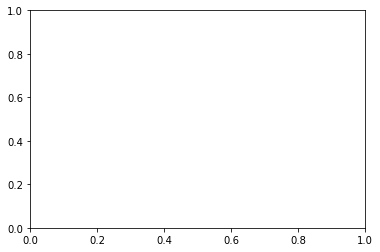

In [15]:
#test
plt.plot( df_obj_0.woe); plt.grid()

In [ ]:

path_file = 'C:\\Users\\sophia.yue\\Infosys\\Sandeep Project\\usb_woe.chart.xlsx'
writer = pd.ExcelWriter(path_file)
#sheet_name = 'woe for type = obj'

s_row =0; s_col = 0
max_col = [0, 0]
for i in range(0, 1):
    df_woe_obj = globals()[f'df_obj_{i}'] 
    df_woe_obj.to_excel(writer, sheet_name = sheet_name, startrow = s_row, startcol = s_col, index = False)
    max_col, workbook, worksheet = f_adj_col_sheet(df_woe_obj, writer, sheet_name, True, max_col)
    s_row += len(df_woe_obj) + 2 
    chart1 =  workbook.add_chart({'type' : 'Column'})
    chart1.add_series({'categories':'=Sheet1!$B$3:$B$9',
                     'values' : '=Sheet1!$H$3:!$H$9',})
    chart1.set_x_axis({'name': 'WOE'})
    chart1.set_y_axis({'name': 'Value'})
    chart1.set_title ({'name': 'WOE-value'})
    worksheet.insert_chart('E9', chart1)
    workbook.close()
    

## Calculate WOE from cross_tab 

In [ ]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile

In [ ]:

path_file = "C:\\Users\\sophia.yue\\Infosys\\Sandeep Project\\wip Payment Audit Modeling 20180130 v1.xlsx"
df = pd.read_excel(path_file, engine = 'openpyxl', sheet_name = 'WoE_wip', index_col ='Value')
dfx = df.copy()

In [ ]:
round(dfx['ivcontrib'].sum(), 4)

In [ ]:
df = dfx.copy()
(inf, dfy) = inf_value( df , verb=True )

In [ ]:
fea

In [ ]:
 (ivx, dfx) =  infValuex( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )

In [ ]:
def infValuex( x, y, labels=(0,1), names=('Neg', 'Pos'), mins=(1,1), offsets=(0,0), verb=False ):

    a  = pd.crosstab( x, y ) 
    labs2keep=[g for g in a.columns if g in labels ]
    a = a[labs2keep]
    a.columns = names
    
    if sum(offsets) > 0 :
        a = a + offsets
    
    #  Create column containing Column Percentages
    pct_cols = ['Pct_'+b for b in a.columns]
    for i in range(len(a.columns)):
        a[pct_cols[i]]=round(a[a.columns[i]]/sum(a[a.columns[i]]), 4)
    
    a['use']       = np.where( np.logical_and( a[a.columns[0]] > mins[0], a[a.columns[1]] > mins[1]), 1, 0)
    a['woe']       = round(np.where( a['use'] == 1, np.log(a[a.columns[len(names)]]/a[a.columns[len(names)+1]]), 0), 4)
  
    inf_val = round(sum( a['ivcontrib'] ), 4)
    
    if verb:
        print('Inf. value = '+ str(inf_val) + ', '+ str(sum(a['use'])) + ' of '+str(len(a['use'])) + ' levels contributing')
        print(a)
        
    return (inf_val, a)

In [ ]:
dfz = dfx.copy()
dfz.insert(loc=0, column='feature', value = '')
dfz

In [ ]:
df['pct_ total'] = (df.Passed + df.Failed)/(df['Passed'].sum() + df.Failed.sum() )

In [ ]:
verb = True
(ivx, dfx) =  infValue( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )
l_sum = [df.col.sum() for col in dfx.columns ]

In [ ]:
l_iv = []
l_iv.append([fea, round(ivx,4)])
#df_iv = pd.DataFrame(dic_iv)
dfz.loc[len(dfz)] = l_iv
dfz

In [ ]:
l_sum

In [ ]:
dfx.columns

In [ ]:
dic_iv = {}
dic_iv.update({fea:round(ivx,4)})
df_iv = pd.DataFrame(dic_iv)
df_iv

In [ ]:

plt.plot( dfx.woe); plt.grid()

In [ ]:
df_iv

In [ ]:
"""
1. Invoke "infValue" to
   - dfx data frame for labels, oe and ivcontrib
   - iv4: Information value (sum of ivcontrib)
2. Create a list l_sum to sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined', and ' ivcontrib'  
   - # not calculate 'use' and 'Woe'
"""
l_iv=[]
l_col_obj = ['Other_NonBankCard']
col_dfx = ['Approved',  'Declined',  'Pct_Approved', 'Pct_Declined'] 
draw_ind = False
dfy = pd.DataFrame()
verb= True
for fea in l_col_obj:
        (ivx, dfx) =  infValue( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )
        
        if draw_ind:
           plt.plot( dfx.woe); plt.grid()
        # get sum    
        l_sum = ['', 'Total']
        l_sum.extend([dfx[col].sum() for col in col_dfx ]) # sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined'
        l_sum.extend(['', '']) # not calculate 'use' and 'Woe'
        l_sum.append( round(dfx['ivcontrib'].sum(), 4))  # add IV
        
        l_fea = [fea] + [''] + ['' for x in dfx.columns]
        columns=['feature'] + ['value'] + dfx.columns.tolist()
        df0 = pd.DataFrame([l_fea],columns=columns)
        
        dfx = dfx.reset_index()
        dfx.rename(columns={fea:'value'},inplace = True)
        dfx.insert(loc=0, column='feature', value = '')
        
        dfx.loc[len(dfx)] = l_sum
        dfy = pd.concat([dfy,  df0, dfx], axis = 0)
        l_iv.append([fea, round(ivx, 4)]) 
df_iv = pd.DataFrame(l_iv,columns=['feature','iv'])      

In [ ]:
dfy

In [ ]:
df.dtypes[df.dtypes == 'O'].index.tolist() 

In [ ]:
df.dtypes[df.dtypes != 'O'].index.tolist() 

In [ ]:
def crx_woe_iv(df, l_col, pr_typ, verb = False,  draw_ind = False):
    """
    module name : cr_woe_iv
    Purpose: 
    1. Invoke "infValue/infValueEquibin" to create
       - dfx: A data frame for feature values, woe and ivcontrib
       - ivx: Information value (sum of ivcontrib)
    2. Create a list l_sum to sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined', and ' ivcontrib'  
       - Not calculate the sum for 'use' and 'Woe'
    Parameters
      input: 
        df: data frame to calculate woe and iv
        l_col: list of columns to calculate woe and iv
        pr_tpy: Process type 
          obj: Process woe and iv for object features
          num: Process woe and iv for numeric features 
        verb: Indicator to verbose
        draw_ind: Indicator to draw the plot for woe
      output:
        dfy: data frame to capture value counts of 'Apprroved', counts of 'Declined', 'Pct_Approved', 'Pct_Declined', and ' ivcontrib'  
        dfz: data frame to capture  feature name of iv
    """
    l_iv=[]
    col_dfx = ['Approved',  'Declined',  'Pct_Approved', 'Pct_Declined'] 

    dfy = pd.DataFrame()
    for fea in l_col:
            print(f'fea, {fea}')
            if pr_typ == 'obj':
               (ivx, dfx) =  infValue( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )
            else:
               infValueEquibin( df[fea], df['target'], n=7, verb= verb, mins=(1,1), names=('Approved','Declined') )
            
            if draw_ind:
               plt.plot( dfx.woe); plt.grid()
            # get sum    
            l_sum = ['', 'Total']
            l_sum.extend([dfx[col].sum() for col in col_dfx ]) # sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined'
            l_sum.extend(['', '']) # not calculate 'use' and 'Woe'
            l_sum.append( round(dfx['ivcontrib'].sum(), 4))  # add IV
            l_sum
            l_fea = [fea] + [''] + ['' for x in dfx.columns]
            columns=['feature'] + ['value'] + dfx.columns.tolist()
            df0 = pd.DataFrame([l_fea],columns=columns)
            print(f'df0')
            dfx = dfx.reset_index()
            dfx.rename(columns={fea:'value'},inplace = True)
            dfx.insert(loc=0, column='feature', value = '')
            print(f'dfx')
            dfx.loc[len(dfx)] = l_sum
            dfy = pd.concat([dfy,  df0, dfx], axis = 0)
            print(f'dfy')
            l_iv.append([fea, round(ivx, 4)]) 
            print(f'dfz l_iv {l_iv}')
    df_iv = pd.DataFrame(l_iv,columns=['feature','iv']) 
    return df_iv, dfy

In [ ]:

df_iv_num, df_owe_num = cr_woe_iv(df, l_col_num,pr_typ = 'num', verb = True, draw_ind = True)

In [ ]:
df_new = df[(df.Channel == np.NaN)]
df_new.shape

In [ ]:

(ivx, dfx) =  infValue( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )
  

In [ ]:
type(max_col)


In [ ]:
SLA    Saervice Level Agreement
SOW    Statement of Work
DAQC   Data Analytics Quality Control
ECMO   Enterprise Complaint Management Office
LBP    Look Back period
CRGC   Customer Remediation Governance Committee
CRCD   Customer Remediation Customer Database
ADCON  Address Confidentiality
CRCOE  Customer Remediation Center of Excellence